In [2]:
import numpy as np
from scipy.linalg import expm
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import least_squares

# Functions

In [3]:
def listkap_matkappa(kappa):
    matkappa = np.zeros((no_states,no_states))
    triangle = np.triu(np.ones((no_states, no_states), dtype=bool), k=1) 
    matkappa[triangle]= kappa
    matkappa += matkappa.T
    return matkappa

def matkappa_matr(kappa):
    matkappa = listkap_matkappa(kappa)
    matr = np.zeros((no_states,no_states)) 
    matr = matkappa * eq_pop[:, np.newaxis] 
    rdiag = -np.sum(matr,0)
    matr = matr + np.diag(rdiag)
    return matr

def p_model(exp_r_del_t, p_zero):
    p_model = np.zeros((time_size,no_states))

    p_model[0,:] = p_zero
    for i in range(1,time_size):
        p_model[i,:] = exp_r_del_t.dot(p_model[i-1,:])
    return p_model

def residual_kappaonly(kappa):
    r_of_t = matkappa_matr(kappa)
    expm_rdelt = expm(r_of_t*del_t)
    p_mod = p_model(expm_rdelt,p_zero)
    residual = (population_data-p_mod).flatten()
    return residual


# Data 

In [3]:
column_names = ["Time"]
site_data_path = "../Data/mash_site300K.dat"
for i in range(1,8):
    column_names.append(str(i))
site_df = pd.read_csv(site_data_path, delimiter=" ", names=column_names)
site_df = site_df[(site_df.index % 10 == 0) | (site_df.index == len(site_df.index) - 1)]

t1 = 800
t2 = 1000

# All the values within the df
site_eq = site_df.values 
full_time = site_df["Time"].values

# Only values below t2
site_df = site_df[site_df["Time"]<=t2]
site_values= site_df.values #DF to NP
site_pop = site_values[:,1:]

start_to_t1 = site_values[site_values[:,0]<=t1]
t1_to_t2_full = site_values[site_values[:,0]>=t1]

no_states = 7
eq_pop = site_eq[-1]
eq_pop = eq_pop[1:8]

# Optimization and Residual Calc

In [ ]:
kappa_guess = np.full(21,0.01)
kappa = kappa_guess

#Array of t0 to use
start_to_t1_time = start_to_t1[:,0]
del_t_val = start_to_t1_time[1]-start_to_t1_time[0]

start_time_values = start_to_t1_time[:-10]

t1_to_t2_time = t1_to_t2_full[:,0]
t1_to_t2_pop = t1_to_t2_full[:,1:]

p_zero = start_to_t1[-1]
p_zero = p_zero[1:8]

save_kappas = []
save_resid = []


for index, start_time in enumerate(start_time_values,start=1):
    print(index)
    
    #TRAIN
    t0_to_t1 = start_to_t1[start_to_t1[:,0]>=start_time]
    time_size = len(t0_to_t1)
    t0_to_t1 = t0_to_t1[:,1:]
    population_data = t0_to_t1[::-1]
    del_t = -del_t_val

    least_squares_result = least_squares(residual_kappaonly, kappa, bounds=(0,float("inf")),xtol=None, ftol=1e-8) 

    kappa_optimized = least_squares_result.x
    save_kappas.append(kappa_optimized)
    kappa = kappa_optimized

    #TEST
    population_data = t1_to_t2_full[:,1:]
    time_size = len(t1_to_t2_full)
    del_t = del_t_val

    #RESIDUAL CALC
    resid = residual_kappaonly(kappa_optimized)
    resid = (np.sum(np.abs(resid))**2)/(time_size*7)

    save_resid.append(resid)

save_kappas = np.column_stack((start_time_values,save_kappas))
save_resid = np.column_stack((start_time_values,save_resid))

np.savetxt(f"/u/dem/kebl6911/Part-II/MASH_optimization/t_1_2_Testing/800_1000_resid5.dat", save_resid, delimiter = "\t")
np.savetxt(f"/u/dem/kebl6911/Part-II/MASH_optimization/t_1_2_Testing/800_1000_kap_saved5.dat",save_kappas, delimiter = "\t")

Text(0.5, 0, '$t_0$ [fs]')

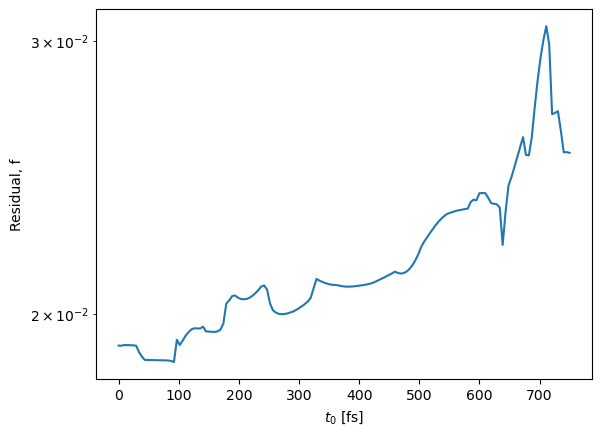

In [5]:
site_residual_data = np.loadtxt("/u/dem/kebl6911/Part-II/MASH_optimization/t_1_2_Testing/800_1000_resid4.dat")

plt.semilogy(site_residual_data[:,0],site_residual_data[:,1])

plt.ylabel('Residual, f')
plt.xlabel(r'$t_0$ [fs]')

In [6]:
kappas = np.loadtxt("/u/dem/kebl6911/Part-II/MASH_optimization/t_1_2_Testing/800_1000_kap_saved4.dat")
kappa_450 = kappas[19]
kappa_450 = kappa_450[1:22]


t1_to_t3_time = full_time[full_time[:]>=t1]
time_size = len(t1_to_t3_time)
r_matrix = matkappa_matr(kappa_450) 
expm_rt = expm(r_matrix*del_t_val)
pop_450 = p_model(expm_rt, p_zero)

start_to_t1_time = start_to_t1[:,0]
start_to_t1_size = len(start_to_t1_time)
time_size = start_to_t1_size
expm_rt = expm(r_matrix*-del_t_val)
pop_450_back = p_model(expm_rt, p_zero)
pop_450_back = pop_450_back[::-1]

pop_450_back = np.column_stack((start_to_t1_time,pop_450_back))
pop_450 = np.column_stack((t1_to_t3_time, pop_450))

pop_450 = np.vstack((pop_450_back,pop_450))
np.savetxt("/u/dem/kebl6911/Part-II/MASH_optimization/t_1_2_Testing/pop_450.dat", pop_450, delimiter = "\t")

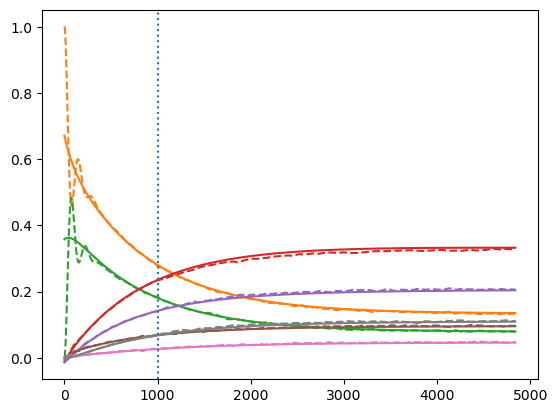

In [7]:
site_data = np.loadtxt(site_data_path)

saved_450 = np.loadtxt("/u/dem/kebl6911/Part-II/MASH_optimization/t_1_2_Testing/pop_450.dat")

for i, column_name in enumerate(column_names[1:], start=1):
    c = "C%i"%i
    plt.plot(site_data[:,0], site_data[:,i],"--", label=column_name, color=c)
    plt.plot(saved_450[:,0],saved_450[:,i], "-",color=c)

plt.axvline(x=1000, linestyle = ":")
plt.show()

# Friday 3rd November

- Fix Fitting window as between 0 fs and 1000 fs,
- Using Kappas from that fitting window, find the residual error in the region 500 fs and 1000 fs and compare the residual error to that calculated for between 1000 fs and 5000 fs

## Data

In [4]:
column_names = ["Time"]
site_data_path = "../Data/mash_site300K.dat"
for i in range(1,8):
    column_names.append(str(i))
site_df = pd.read_csv(site_data_path, delimiter=" ", names=column_names)
site_df = site_df[(site_df.index % 10 == 0) | (site_df.index == len(site_df.index) - 1)]

# All the values within the df
site_eq = site_df.values 
full_time = site_df["Time"].values

t0 = 0
t1 = 500
t2 = 5000
t3 = full_time[-1]

# Only values below t2
site_df = site_df[site_df["Time"]<=t2]
start_to_t2= site_df.values #DF to NP

#EDIT THIS
start_to_t2 = start_to_t2[start_to_t2[:,0]>=t0]
t1_to_t2_full = start_to_t2[start_to_t2[:,0]>=t1]

no_states = 7
eq_pop = site_eq[-1]
eq_pop = eq_pop[1:8]

In [10]:
kappa_guess = np.full(21,0.01)
kappa = kappa_guess

save_kappas = []
save_resid1 = []
save_resid2 = []

# t2s = 40*np.arange(1,101)
t2s = 40*np.arange(1,2)
save_t = []
print(t2s)
for t2 in t2s:
    try:
        t1 = t2/2
        print(t2)
        data = site_df[site_df["Time"]<=t2]
        start_to_t2= data.values #DF to NP
        start_to_t2 = start_to_t2[start_to_t2[:,0]>=t0]
        t1_to_t2_full = start_to_t2[start_to_t2[:,0]>=t1]
        #Array of t0 to use
        start_to_t2_time = start_to_t2[:,0]
        del_t_val = start_to_t2_time[1]-start_to_t2_time[0]

        t1_to_t2_time = t1_to_t2_full[:,0]
        t1_to_t2_pop = t1_to_t2_full[:,1:]

        t0_to_t2_time = start_to_t2[:,0]
        t0_to_t2_pop = start_to_t2[:,1:]

        p_zero = start_to_t2[-1]
        p_zero = p_zero[1:8]

        #TRAIN
        time_size = len(t0_to_t2_time)
        population_data = t0_to_t2_pop[::-1]
        del_t = -del_t_val
        print("train time_size:",time_size)

        least_squares_result = least_squares(residual_kappaonly, kappa, bounds=(0,float("inf")),xtol=None, ftol=1e-8) 
        kappa_optimized = least_squares_result.x
        print("LS loss:",2.*np.sqrt(least_squares_result.cost)/(time_size*no_states))

        #TEST t0-t2
        population_data = t0_to_t2_pop
        time_size = len(population_data)
        del_t = del_t_val
        print("t0-t2 length: ",time_size)
        p_zero = population_data[0,:]
        print("p_zero eval t0-t2:",p_zero)

        #RESIDUAL CALC
        resid1 = residual_kappaonly(kappa_optimized)
        resid1 = np.sqrt(np.sum(resid1**2))/(time_size*no_states)
        print("Resid 1:",resid1)

        #TEST t1-t2
        population_data = t1_to_t2_full[:,1:]
        time_size = len(t1_to_t2_full)
        del_t = del_t_val
        p_zero = population_data[0,:]
        print("t1-t2 length: ",time_size)

        #RESIDUAL CALC
        resid1 = residual_kappaonly(kappa_optimized)
        resid1 = np.sqrt(np.sum(resid1**2))/2
        print("Resid 1:",resid1)

        #TEST ALL
        t2_to_t3_full = site_eq[site_eq[:,0]>=t2]
        t2_to_t3_pop = t2_to_t3_full[:,1:]
        t2_to_t3_time = t2_to_t3_full[:,0]

        population_data = t2_to_t3_pop
        time_size = len(t2_to_t3_time)
        p_zero = population_data[0,:]
        print("t2-t3 length: ",time_size)
        
        r_of_t = matkappa_matr(kappa_optimized)
        expm_rdelt = expm(r_of_t*del_t)
        p_opt = p_model(expm_rdelt, p_zero)
            
        resid2 = residual_kappaonly(kappa_optimized)
        resid2 = np.sqrt(np.sum(resid2**2))/2.
        print("Resid 2:",resid2)

        save_kappas.append(kappa_optimized)
        save_resid1.append(resid1)
        save_resid2.append(resid2)
        
        save_t.append(t2)
    except Exception as e:
        print("failed for t2=",t2)
        print(e)
        continue

save_t = np.array(save_t)
save_kappas = np.array(save_kappas)
save_kappas = np.column_stack((save_t,save_kappas))
save_resid1 = np.column_stack((save_t,save_resid1))
save_resid2 = np.column_stack((save_t,save_resid2))

np.savetxt(f"scan_0_5000_resid1.dat", save_resid1, delimiter = "\t")
np.savetxt(f"scan_0_5000_resid2.dat", save_resid2, delimiter = "\t")
np.savetxt(f"scan_0_5000_kap_saved.dat",save_kappas, delimiter = "\t")

[40]
40
train time_size: 9
LS loss: 0.006024779688841528
t0-t2 length:  9
p_zero eval t0-t2: [ 1.00065737e+00  1.02958332e-03 -5.85211076e-04 -4.75690487e-04
 -1.93274821e-03  5.21953733e-04  7.84741210e-04]
Resid 1: 0.006047268223749637
t1-t2 length:  4
Resid 1: 0.032941563508619744
t2-t3 length:  992
Resid 2: 0.9685369396783602


## Calculate and Plot the Data

In [32]:
#Forwards population from 1000 fs
time_size = len(t2_to_t3_time)
r_matrix = matkappa_matr(kappa_optimized) 
expm_rt = expm(r_matrix*del_t_val)
pop = p_model(expm_rt, p_zero)

#Back popualtion from 1000 fs
time_size = len(t0_to_t2_time)
expm_rt = expm(r_matrix*-del_t_val)
pop_back = p_model(expm_rt, p_zero)
pop_back = pop_back[::-1]

pop_back = np.column_stack((t0_to_t2_time,pop_back))
pop = np.column_stack((t2_to_t3_time, pop))

pop_full = np.vstack((pop_back,pop))

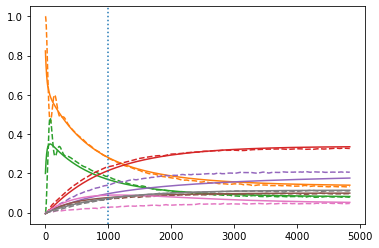

In [33]:
site_data = np.loadtxt(site_data_path)

for i, column_name in enumerate(column_names[1:], start=1):
    c = "C%i"%i
    plt.plot(site_data[:,0], site_data[:,i],"--", label=column_name, color=c)
    plt.plot(pop_full[:,0], pop_full[:,i], "-",color=c)

plt.axvline(x=1000, linestyle = ":")
plt.show()

In [35]:

t2s = 10*np.arange(1,101)
print(t2s)

[  10   20   30   40   50   60   70   80   90  100  110  120  130  140
  150  160  170  180  190  200  210  220  230  240  250  260  270  280
  290  300  310  320  330  340  350  360  370  380  390  400  410  420
  430  440  450  460  470  480  490  500  510  520  530  540  550  560
  570  580  590  600  610  620  630  640  650  660  670  680  690  700
  710  720  730  740  750  760  770  780  790  800  810  820  830  840
  850  860  870  880  890  900  910  920  930  940  950  960  970  980
  990 1000]
